# Intro
---
To preface, I am not strong at stats. This is a work in progress. Any feedback would be much appreciated.

This notebook is to test a claim made by some chief trader from this article: https://investorplace.com/smartmoney/2025/10/the-great-silver-shortage-why-prices-are-poised-to-break-out-again/


He states that given the **silver-gold ratio (SGR)** is *less than ($<$) 1.3%*, silver prices are poised to increase. My hypothesis is that this is not correct. We will use future prices for the ratio and compare it to silver futures. We must also acknowledge that the data are time series. So what is the best model and test for this case?

First we will analyze average return for when the signal is active (when SGR is $<1.3\%$) compared to when it's not (when SGR is $\geq1.3\%$). We are looking for short term returns when the signal is activated. 

Then we will do a simple regressoin on SI futures against time to see if the price increases. A greater slope will indicated greater returns (for each day, price goes up per slope amount). This is not a correlation test.

Then we will use modern tools to model and test. We will not use classical. We will stationize the time series by viewing day-to-day percentage change. Then we will test that it is stationary using the Augmented dickey fuller test (I think).

In [62]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.api import VAR
from scipy import stats
import matplotlib.pyplot as plt
import os

In [ ]:
def clean_existing_csvs():
    '''This cleans up the indeces of CSV. My local CSVs were disorganized'''
    base_dir = os.getcwd()
    folder_path = os.path.join(base_dir, "data")
    if not os.path.exists(folder_path):
        return
    for f in os.listdir(folder_path):
        if f.endswith(".csv"):
            path = os.path.join(folder_path, f)
            # Read while skipping junk header rows
            df = pd.read_csv(path, skiprows=[1,2], index_col=0)
            # Flatten multiindex if any
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = ['_'.join(col).strip() for col in df.columns.values]
            # Drop NaN rows created by the "Date" line
            df = df[df.index.notna()]
            # Overwrite cleaned file
            df.to_csv(path, index=True)
            print(f"Cleaned {f}")
            
def fetch_data(symbol):
    '''Get local data. If it does not exist, pull from yfinance'''
    base_dir = os.getcwd()
    folder_path = os.path.join(base_dir, "data")
    os.makedirs(folder_path, exist_ok=True)
    cache_file = f"{symbol.replace('=','-')}.csv"
    file_path = os.path.join(folder_path, cache_file)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        print(f"Loaded cached data for {symbol}")
    else:
        df = yf.download(symbol, start='1990-01-01', auto_adjust=True)[['Open', 'Close']]
        df.to_csv(file_path)
        print(f"Downloaded and cached data for {symbol}")
        
    # rename columns to prevent duplicates after concat
    df.columns = [f"{symbol}_Open", f"{symbol}_Close"]
    return df

In [8]:
clean_existing_csvs()

Cleaned GC-F.csv
Cleaned GLD.csv
Cleaned test_ticker.csv
Cleaned SLV.csv
Cleaned SI-F.csv


In [81]:
# Fetch data from Yahoo and only take the closing prices to model
silver = fetch_data('SI=F')
gold = fetch_data('GC=F')

df = pd.concat([silver, gold], axis=1, join='inner')

df = df.drop(df.filter(regex='_Open$').columns, axis=1)
df.head()

Loaded cached data for SI=F
Loaded cached data for GC=F


,SI=F_Close,GC=F_Close
Price,,
2000-08-30,4.930,273.899994
2000-08-31,5.003,278.299988
2000-09-01,5.004,277.000000
2000-09-05,4.998,275.799988
2000-09-06,4.983,274.200012


In [82]:
# Create SGR column
df['SGR'] = df['SI=F_Close'] / df['GC=F_Close']
df.head()

,SI=F_Close,GC=F_Close,SGR
Price,,,
2000-08-30,4.930,273.899994,0.017999
2000-08-31,5.003,278.299988,0.017977
2000-09-01,5.004,277.000000,0.018065
2000-09-05,4.998,275.799988,0.018122
2000-09-06,4.983,274.200012,0.018173


In [83]:
# We will define the signal to be 0 when disabled and 1 when active
df['signal'] = (df['SGR'] < 0.013).astype(int)
df['return_next'] = df['SI=F_Close'].pct_change().shift(-1)
df = df.dropna()
df.head()

,SI=F_Close,GC=F_Close,SGR,signal,return_next
Price,,,,,
2000-08-30,4.930,273.899994,0.017999,0,0.014807
2000-08-31,5.003,278.299988,0.017977,0,0.000200
2000-09-01,5.004,277.000000,0.018065,0,-0.001199
2000-09-05,4.998,275.799988,0.018122,0,-0.003001
2000-09-06,4.983,274.200012,0.018173,0,-0.009633


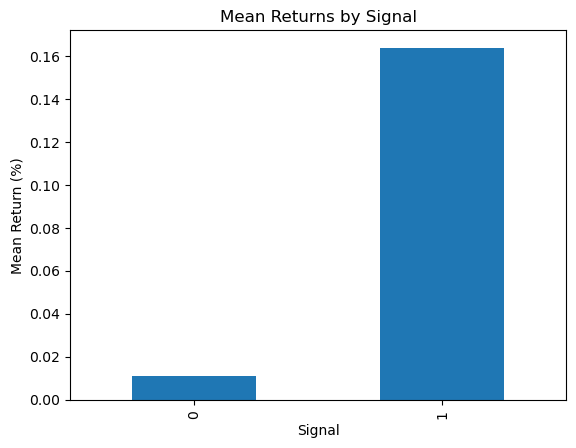

mean 0: 0.011 
mean 1: 0.164


In [84]:
signal_group = df.groupby('signal')['return_next']

means = signal_group.mean() * 100
vars_ = signal_group.var()

mean_0, mean_1 = round(means.loc[0], 3), round(means.loc[1], 3)
var_0, var_1 = vars_.loc[0], vars_.loc[1]

# Optional: visualize mean returns by signal
means.plot(kind='bar', title='Mean Returns by Signal')
plt.xlabel("Signal")
plt.ylabel("Mean Return (%)")
plt.show()
print(f"mean 0: {mean_0} \nmean 1: {mean_1}")



The signal indicates significant short term returns if you hold your posiitons through when the signal is active! So maybe the claim is right.

We can use a $t$-test to rigorously verify, but the data violates assumptions so it won't be telling.

In [85]:
# # Drop the any date before the first occurence of SGR < 1.13% since it is just noise this case
# df = df.loc[df.index >= '2003-02-04']
# df.head()

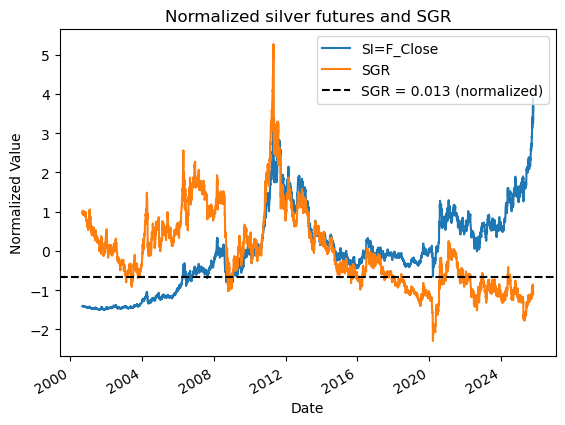

Correlation: 0.06609787325083215


In [86]:
# Now we check correlation and graph the time series
df_norm = (df - df.mean()) / df.std()
df_norm[['SI=F_Close', 'SGR']].plot(title='Normalized silver futures and SGR')
sgr_line = (0.013 - df['SGR'].mean()) / df['SGR'].std()
plt.axhline(y=sgr_line, color='black', linestyle='--', label='SGR = 0.013 (normalized)')

plt.xlabel("Date")
plt.ylabel("Normalized Value")


plt.legend()
plt.show()

print(f'Correlation: {df['SI=F_Close'].corr(df['SGR'])}')

What if we make the data stationary?

In [87]:
# Stationize the data
df['SI% change'] = df['SI=F_Close'].pct_change()
df['SGR% change'] = df['SGR'].pct_change()
df.head()

,SI=F_Close,GC=F_Close,SGR,signal,return_next,SI% change,SGR% change
Price,,,,,,,
2000-08-30,4.930,273.899994,0.017999,0,0.014807,NaN,NaN
2000-08-31,5.003,278.299988,0.017977,0,0.000200,0.014807,-0.001237
2000-09-01,5.004,277.000000,0.018065,0,-0.001199,0.000200,0.004894
2000-09-05,4.998,275.799988,0.018122,0,-0.003001,-0.001199,0.003147
2000-09-06,4.983,274.200012,0.018173,0,-0.009633,-0.003001,0.002816


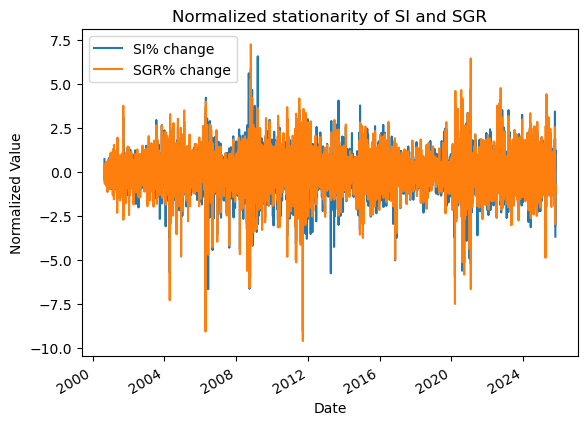

Correlation: 0.8510484769351793


In [88]:
# Now we check correlation and graph the time series
df_norm = (df - df.mean()) / df.std()
df_norm[['SI% change', 'SGR% change']].plot(title='Normalized stationarity of SI and SGR')

plt.xlabel("Date")
plt.ylabel("Normalized Value")


plt.legend()
plt.show()

print(f'Correlation: {df['SI% change'].corr(df['SGR% change'])}')

There we go! Highly correlated! This implies that SI moves with SGR, whic makes sense since they are dependent on one another. In this case, SGR likely has no *predictive* power over SI. Just because it moves with it doesn't mean it can predict price. So how do we test predictive power?

In [95]:
# Build VAR model
df_stat = df[['SI% change', 'SGR% change']].iloc[1:]

model_var = VAR(df_stat)
results_var = model_var.fit(maxlags=7, ic='aic')  # Use AIC to select lag order
print(results_var.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 25, Oct, 2025
Time:                     16:50:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -17.7798
Nobs:                     6300.00    HQIC:                  -17.8008
Log likelihood:           38258.9    FPE:                1.83817e-08
AIC:                     -17.8119    Det(Omega_mle):     1.82945e-08
--------------------------------------------------------------------
Results for equation SI% change
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.000581         0.000250            2.329           0.020
L1.SI% change         -0.011232         0.024067           -0.467           0.641
L1.SGR% change        -0.021371         0.035942   

/opt/miniconda3/envs/tasty/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Short term predictive power is weak. 

I believe classical models and tests are not the best for this study, so next time I will implement modern models and test!

In [21]:
# ==========================================
# 1. XGBoost Regression for Silver Returns
# ==========================================
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# Feature engineering: lag features
lags = 5
for i in range(1, lags + 1):
    df[f'slv_ret_lag{i}'] = df['slv_ret'].shift(i)
    df[f'sgr_ret_lag{i}'] = df['sgr_ret'].shift(i)

df_ml = df.dropna(subset=['slv_ret', 'sgr_ret'])
features = [col for col in df_ml.columns if 'lag' in col]
X = df_ml[features]
y = df_ml['slv_ret']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time-series split (no leakage)
tscv = TimeSeriesSplit(n_splits=5)
y_true, y_pred = [], []

for train_idx, test_idx in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4)
    model.fit(X_train, y_train)
    y_pred.extend(model.predict(X_test))
    y_true.extend(y_test)

print("R²:", r2_score(y_true, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))


R²: -0.1478944556661066
RMSE: 0.021517919872288026


In [ ]:
# ==========================================
# 2. GRU (Gated Recurrent Unit)
# ==========================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler

# Prepare time window data
lookback = 30
data = df[['slv_ret', 'sgr_ret']].dropna()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

X, y = [], []
for i in range(lookback, len(data_scaled)-1):
    X.append(data_scaled[i-lookback:i])
    y.append(data_scaled[i+1, 0])  # predict next silver return
X, y = np.array(X), np.array(y)

# Train-test split (time-based)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# GRU model
model = Sequential([
    GRU(64, input_shape=(lookback, X.shape[2]), dropout=0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Evaluation
preds = model.predict(X_test)
rmse = np.sqrt(np.mean((preds.flatten() - y_test)**2))
print("RMSE:", rmse)


In [ ]:
# ==========================================
# 3. Hidden Markov Model
# ==========================================
from hmmlearn.hmm import GaussianHMM

# Use 2 or 3 regimes
X = df[['slv_ret', 'sgr_ret']].dropna().values

hmm = GaussianHMM(n_components=3, covariance_type="full", n_iter=200)
hmm.fit(X)
states = hmm.predict(X)
df['regime'] = np.nan
df.loc[df.dropna(subset=['slv_ret', 'sgr_ret']).index, 'regime'] = states

plt.figure(figsize=(10,4))
plt.plot(df['slv_ret'], label='Silver Return', alpha=0.6)
plt.scatter(df.index, df['slv_ret'], c=df['regime'], cmap='viridis', s=10)
plt.title('Hidden Markov Regimes in Silver Returns')
plt.legend()
plt.show()


In [ ]:
# ==========================================
# 4. Markov Chain Transition Probabilities
# ==========================================
from collections import Counter
import numpy as np

# Discretize returns into 3 states: -1 (down), 0 (flat), 1 (up)
ret = df['slv_ret'].dropna()
quantiles = ret.quantile([0.33, 0.66])
states = np.select(
    [ret < quantiles.iloc[0], ret < quantiles.iloc[1]], 
    [-1, 0], 
    default=1
)

# Build transition matrix
transitions = pd.crosstab(states[:-1], states[1:], normalize='index')
print("Transition Probabilities:")
print(transitions)


In [ ]:
import sys
print(sys.executable)
